In [39]:
import pylab
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import geometric_transform
global fps
fps = 20.

from skimage.measure import block_reduce


global origin
global origin_init
global v0,v1,h0,h1

origin_init = (310,215) ## approximate centroid of video frame
origin = origin_init ## to be updated later

In [40]:
test_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/test.mp4'

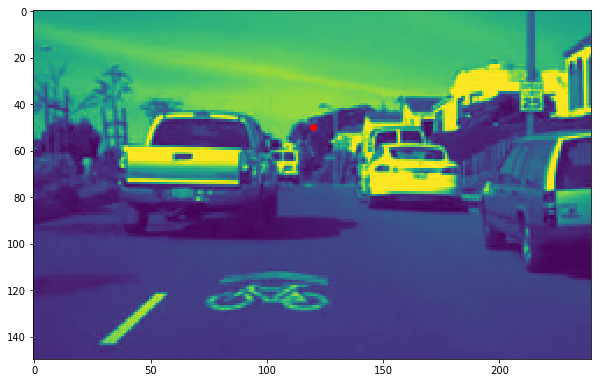

In [44]:
## Try loading a few fraes and mark the origin
vid = imageio.get_reader(test_vid,  'ffmpeg')
nums = [9080,9081,9082]
vid_frames = []
image = vid.get_data(0)
#print(image.shape[0])

v0 = origin_init[0] - 120
v1 = origin_init[0] + 120
h0 = origin_init[1] - 50
h1 = origin_init[1] + 100
origin = (120,50)

for num in nums:
    image = vid.get_data(num)
    vid_frames.append(image[h0:h1,v0:v1])

im = vid_frames[0][:,:,1]
plt.figure(figsize = (10,10))
plt.imshow(im)

plt.plot(origin[0],origin[1],'ro')

## Get the video dimensions
v = vid_frames[0].shape[0]
h = vid_frames[0].shape[1]
#print(v)

Compute optic flow (Farneback method) on pairs of frames, and apply same algorithm to compute acceleration. Code modified to include 3 frames instead of 2, which enables the acceleration computation

In [43]:
## Preproc data
def opticalFlowFarneback(image_current, image_next,win_size = 5):    
    flow_im = np.zeros((image_current.shape[0],image_current.shape[1],2))
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(image_current, image_next,  
                                        flow_mat, image_scale, 
                                        nb_images, win_size, 
                                        nb_iterations, deg_expansion, 
                                        STD, 0)                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    flow_im[:,:,0] =  ang* (180/ np.pi / 2) #cv2.normalize(ang,None,0,255,cv2.NORM_MINMAX) #ang* (180/ np.pi / 2)
    flow_im[:,:,1] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    flow_im = np.asarray(flow_im, dtype= np.float32)
    return flow_im.astype('uint8')

def bw_video_frame(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def get_opflow(fr0, fr1, fr2):
    #raw_diff = (fr1-fr0)**0.5
    dat = np.zeros((fr0.shape[0],fr0.shape[1],3))
    flow = opticalFlowFarneback(fr1,fr2,win_size = 2)
    flow2  = opticalFlowFarneback(fr1,fr0,win_size = 2)
    #dat[:,:,0] = fr1 # Option to remove the angle information#flow[:,:,0]
    dat[:,:,0] = flow[:,:,0] # Option to remove the angle information#

    dat[:,:,1] = flow[:,:,1]**0.5
    acc = flow2-flow
    dat[:,:,2] = acc[:,:,1]
    return dat

In [47]:
## Brightness_augment and process
im = 0
fr2 = bw_video_frame(vid_frames[im+2])
fr1 = bw_video_frame(vid_frames[im+1])
fr0 = bw_video_frame(vid_frames[im])

flow = get_opflow(fr0, fr1, fr2)

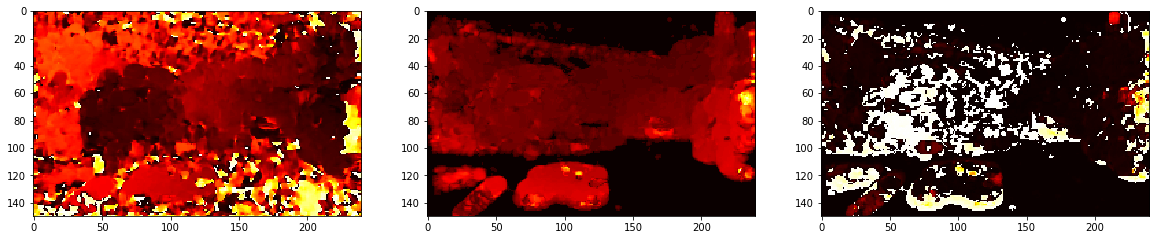

In [48]:
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.imshow(flow[:,:,0],cmap = 'hot')
plt.subplot(132)
plt.imshow(flow[:,:,1],cmap = 'hot')#[:,:,2],cmap = 'gray')
plt.subplot(133)
plt.imshow(flow[:,:,2],cmap = 'hot')#[:,:,2],cmap = 'gray')

In [50]:
import time
np.random.seed(2)
def preproc_and_save_im(vid, path,fr, i_save, imAp, imApp):
    image = vid.get_data(fr)[h0:h1,v0:v1]
    imA = bw_video_frame(image)
    datA = get_opflow(imA, imAp, imApp)     
    #datA = block_reduce(datA, block_size=(3, 3, 1), func=np.median)
                
    fle_name = path+'Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, datA)
    return imA
    
def preproc_test_vid():    
    
    test_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/test.mp4'
    vid = imageio.get_reader(test_vid,  'ffmpeg')
    
    test_path = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Test/'
    
    maxFrames = 10798

    vidframes_test = []
    i_save = 0
    
    image = vid.get_data(0)[h0:h1,v0:v1]
    imApp = bw_video_frame(image)
    image = vid.get_data(1)[h0:h1,v0:v1]
    imAp = bw_video_frame(image)
    
    ## Extend image 2 into frames 0 and 2
    image = vid.get_data(2)[h0:h1,v0:v1]
    imA = bw_video_frame(image)
    datA = get_opflow(imA, imAp, imApp)     
    
  #  datA = block_reduce(datA, block_size=(5, 5, 1), func=np.max)
    
    fle_name = test_path+'/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, datA)
    i_save += 1
    fle_name = test_path+'/Im'+str(i_save)+'.png'
    cv2.imwrite(fle_name, datA)
    i_save += 1
            
    tic = time.time()
    
    for fr in np.arange(2,maxFrames,1):
        imA = preproc_and_save_im(vid, test_path ,fr, i_save, imAp, imApp)

        i_save += 1
        
        ## update timesteps from op flow calculations
        imApp = imAp.copy()
        imAp = imA.copy()
        
        if np.mod(fr,1000)==0:
            t = time.time()-tic
            print('Processed %d of %d Step time %.2f sec'%(fr,maxFrames,t))
            tic = time.time()

preproc_test_vid()

Processed 1000 of 10798 Step time 53.60 sec
Processed 2000 of 10798 Step time 52.07 sec
Processed 3000 of 10798 Step time 52.90 sec
Processed 4000 of 10798 Step time 51.99 sec
Processed 5000 of 10798 Step time 62.23 sec
Processed 6000 of 10798 Step time 62.33 sec
Processed 7000 of 10798 Step time 60.40 sec
Processed 8000 of 10798 Step time 70.07 sec
Processed 9000 of 10798 Step time 66.64 sec
Processed 10000 of 10798 Step time 65.93 sec
